# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Time Series Modeling 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q6"> 5. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import warnings
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

plt.style.use("classic")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
%matplotlib inline

In [2]:
# Loading the data
df = pd.read_csv("crime_reports.csv")

## II. Data Scrubbing

There are several columns of data we don't need. We'll drop those and also scrub the Columns were keeping for analysis. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The 'clearance status' column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed it to boolean type:  Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice. I also converted the 'family violence' column to boolean type.  

In [3]:
def clean_data(df):
    drop_col = [
        "Occurred Time",
        "Incident Number",
        "Occurred Date",
        "Highest Offense Code",
        "Family Violence",
        "Clearance Status",
        "Report Date",
        "Report Time",
        "Clearance Date",
        "Census Tract",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    clean_col = ["Occurred Date Time", "Report Date Time"]
    df.drop(drop_col, axis=1, inplace=True)
    df.dropna(subset=clean_col, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    date_col = ["occurred_date_time", "report_date_time"]
    cat_col = ["highest_offense_description", "location_type", "apd_sector"]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.day
    df["hour"] = pd.to_datetime(df["occurred_date_time"], format="%m/%d/%Y").dt.hour
    df.set_index(["occurred_date_time"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

#### Overall crime rates over time 

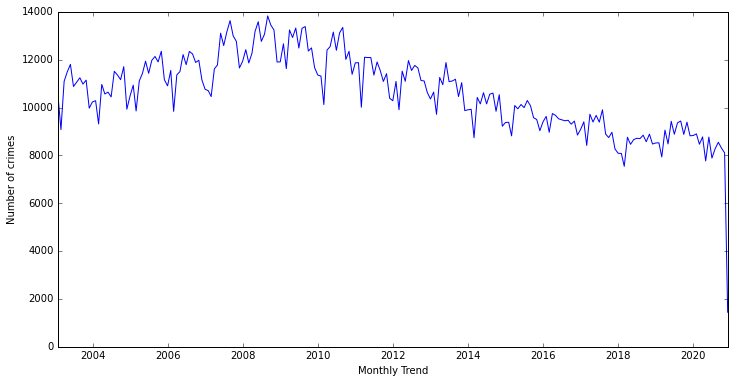

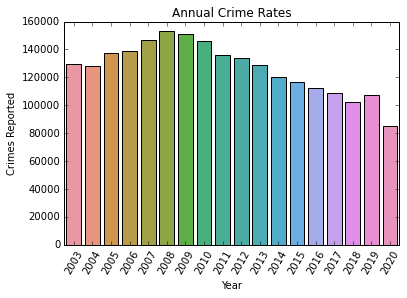

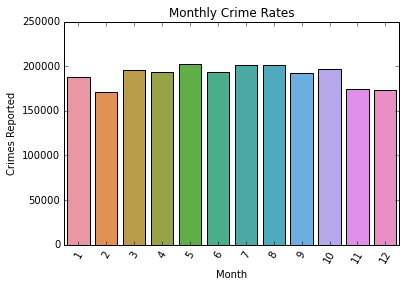

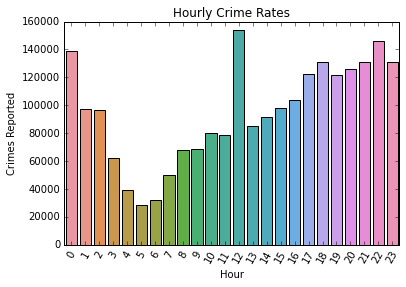

In [4]:
# plotting trend on a weekly basis

plt.figure(figsize=(12, 6))
plt.plot(df.resample("M").size())
plt.xlabel("Monthly Trend")
plt.ylabel("Number of crimes")
plt.show()

# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_year = df["year"].value_counts().sort_index()

g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), rotation=60)
g.set(xlabel="Year", ylabel="Crimes Reported", title="Annual Crime Rates")
plt.show()

# Creating and visualizing a data frame for the overall yearly crime rate since 2003

crimes_per_month = df["month"].value_counts().sort_index()

d = sns.barplot(x=crimes_per_month.index, y=crimes_per_month.values)
d.set_xticklabels(d.get_xticklabels(), rotation=60)
d.set(xlabel="Month", ylabel="Crimes Reported", title="Monthly Crime Rates")
plt.show()

# Overall hourly crime rates as well

crimes_per_hour = df["hour"].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), rotation=60)
e.set(xlabel="Hour", ylabel="Crimes Reported", title="Hourly Crime Rates")
plt.show()

#### Top 50 crime types 

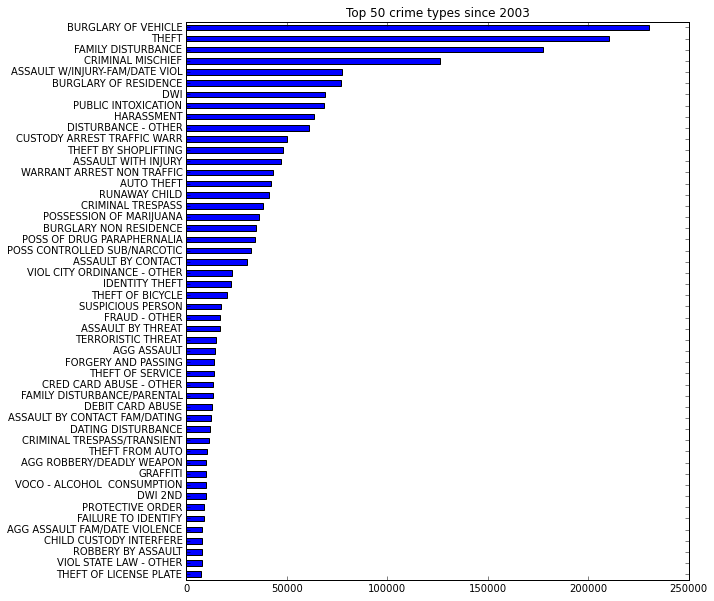

In [5]:
df.highest_offense_description.value_counts().head(50).sort_values().plot.barh(
    figsize=(9, 10), title="Top 50 crime types since 2003"
)

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    205278
78753.0    177342
78701.0    167511
78758.0    157708
78704.0    153476
78745.0    149670
78702.0    136035
78744.0    125301
78723.0    117430
78752.0     83878
78748.0     67458
78759.0     65709
78751.0     63618
78757.0     57327
78705.0     56602
78721.0     47393
78749.0     40118
78724.0     37377
78727.0     35536
78703.0     34937
78731.0     28393
78746.0     27942
78729.0     25411
78750.0     23444
78754.0     22531
Name: zip_code, dtype: int64

----------------------------------


78741.0    0.090474
78753.0    0.078162
78701.0    0.073829
78758.0    0.069508
78704.0    0.067643
78745.0    0.065966
78702.0    0.059956
78744.0    0.055225
78723.0    0.051756
78752.0    0.036968
78748.0    0.029731
78759.0    0.028961
78751.0    0.028039
78757.0    0.025266
78705.0    0.024947
78721.0    0.020888
78749.0    0.017682
78724.0    0.016474
78727.0    0.015662
78703.0    0.015398
78731.0    0.012514
78746.0    0.012315
78729.0    0.011200
78750.0    0.010333
78754.0    0.009930
Name: zip_code, dtype: float64

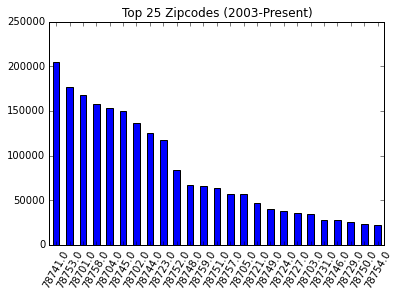

In [6]:
# Create and show dataframe for crime rates by zipcode and then as percentages

zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print("----------------------------------")
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime

df.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 Zipcodes (2003-Present)"
)
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.14%. This is a significant 1.29 percentage points higher than the number 2 area 78753 which hosts 7.85% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741 & 78745. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             17027
BURGLARY OF VEHICLE               15855
FAMILY DISTURBANCE                14478
CRIMINAL MISCHIEF                  9354
THEFT BY SHOPLIFTING               7577
ASSAULT W/INJURY-FAM/DATE VIOL     7083
BURGLARY OF RESIDENCE              6027
DWI                                4928
DISTURBANCE - OTHER                4722
CUSTODY ARREST TRAFFIC WARR        4335
HARASSMENT                         4200
AUTO THEFT                         4128
POSS OF DRUG PARAPHERNALIA         3717
PUBLIC INTOXICATION                3358
ASSAULT WITH INJURY                3268
CRIMINAL TRESPASS                  3117
POSS CONTROLLED SUB/NARCOTIC       2955
RUNAWAY CHILD                      2912
WARRANT ARREST NON TRAFFIC         2787
POSSESSION OF MARIJUANA            2689
BURGLARY NON RESIDENCE             2467
VIOL CITY ORDINANCE - OTHER        1865
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096012
BURGLARY OF VEHICLE               0.089404
FAMILY DISTURBANCE                0.081639
CRIMINAL MISCHIEF                 0.052746
THEFT BY SHOPLIFTING              0.042725
ASSAULT W/INJURY-FAM/DATE VIOL    0.039940
BURGLARY OF RESIDENCE             0.033985
DWI                               0.027788
DISTURBANCE - OTHER               0.026627
CUSTODY ARREST TRAFFIC WARR       0.024444
HARASSMENT                        0.023683
AUTO THEFT                        0.023277
POSS OF DRUG PARAPHERNALIA        0.020960
PUBLIC INTOXICATION               0.018935
ASSAULT WITH INJURY               0.018428
CRIMINAL TRESPASS                 0.017576
POSS CONTROLLED SUB/NARCOTIC      0.016663
RUNAWAY CHILD                     0.016420
WARRANT ARREST NON TRAFFIC        0.015715
POSSESSION OF MARIJUANA           0.015163
BURGLARY NON RESIDENCE            0.013911
VIOL CITY ORDINANCE - OTHER       0.010516
Name: highest_offense_description, dtype: float64

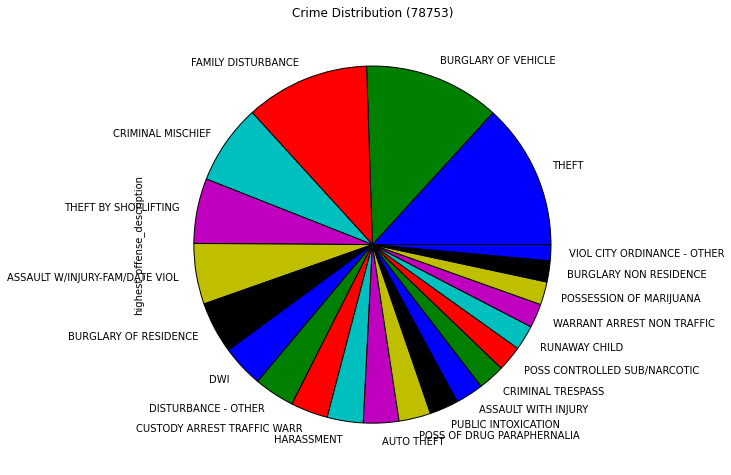

In [7]:
# Examining crime in the 78753 area

df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode

df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_53_off)
print("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20141
BURGLARY OF VEHICLE               19725
THEFT                             15490
CRIMINAL MISCHIEF                 10963
ASSAULT W/INJURY-FAM/DATE VIOL     9580
BURGLARY OF RESIDENCE              8839
PUBLIC INTOXICATION                6367
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5623
HARASSMENT                         5453
DISTURBANCE - OTHER                5124
AUTO THEFT                         4553
ASSAULT WITH INJURY                4509
CRIMINAL TRESPASS                  3879
POSS CONTROLLED SUB/NARCOTIC       3831
POSSESSION OF MARIJUANA            3790
THEFT BY SHOPLIFTING               3565
POSS OF DRUG PARAPHERNALIA         3524
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2778
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098116
BURGLARY OF VEHICLE               0.096089
THEFT                             0.075459
CRIMINAL MISCHIEF                 0.053406
ASSAULT W/INJURY-FAM/DATE VIOL    0.046668
BURGLARY OF RESIDENCE             0.043059
PUBLIC INTOXICATION               0.031016
CUSTODY ARREST TRAFFIC WARR       0.029282
DWI                               0.027392
HARASSMENT                        0.026564
DISTURBANCE - OTHER               0.024961
AUTO THEFT                        0.022180
ASSAULT WITH INJURY               0.021965
CRIMINAL TRESPASS                 0.018896
POSS CONTROLLED SUB/NARCOTIC      0.018662
POSSESSION OF MARIJUANA           0.018463
THEFT BY SHOPLIFTING              0.017367
POSS OF DRUG PARAPHERNALIA        0.017167
WARRANT ARREST NON TRAFFIC        0.016797
RUNAWAY CHILD                     0.013533
VIOL CITY ORDINANCE - OTHER       0.010698
Name: highest_offense_description, dtype: float64

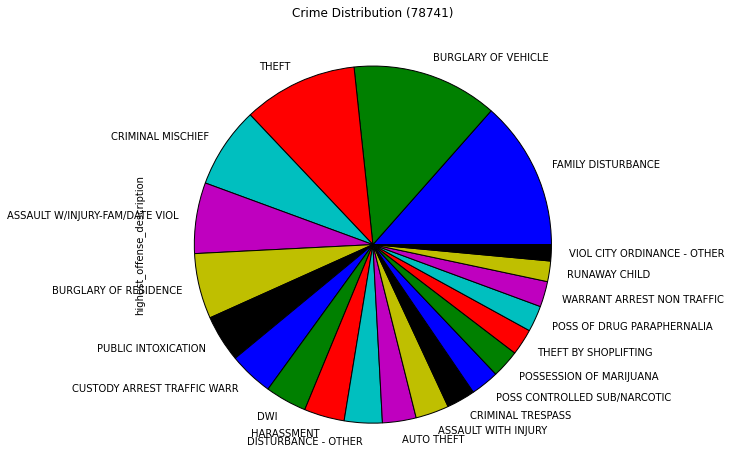

In [8]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)

df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode

df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages

display(df_41_off)
print("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

### D. Question 4. How is crime distributed in 78745?

FAMILY DISTURBANCE                14772
BURGLARY OF VEHICLE               14711
THEFT                             13462
CRIMINAL MISCHIEF                  8440
BURGLARY OF RESIDENCE              5850
ASSAULT W/INJURY-FAM/DATE VIOL     5716
HARASSMENT                         5101
DISTURBANCE - OTHER                4477
DWI                                4393
PUBLIC INTOXICATION                3987
CUSTODY ARREST TRAFFIC WARR        3244
BURGLARY NON RESIDENCE             2906
AUTO THEFT                         2810
ASSAULT WITH INJURY                2640
RUNAWAY CHILD                      2587
POSSESSION OF MARIJUANA            2584
WARRANT ARREST NON TRAFFIC         2107
POSS CONTROLLED SUB/NARCOTIC       2008
THEFT BY SHOPLIFTING               1957
CRIMINAL TRESPASS                  1936
IDENTITY THEFT                     1549
POSS OF DRUG PARAPHERNALIA         1511
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098697
BURGLARY OF VEHICLE               0.098290
THEFT                             0.089945
CRIMINAL MISCHIEF                 0.056391
BURGLARY OF RESIDENCE             0.039086
ASSAULT W/INJURY-FAM/DATE VIOL    0.038191
HARASSMENT                        0.034082
DISTURBANCE - OTHER               0.029912
DWI                               0.029351
PUBLIC INTOXICATION               0.026639
CUSTODY ARREST TRAFFIC WARR       0.021674
BURGLARY NON RESIDENCE            0.019416
AUTO THEFT                        0.018775
ASSAULT WITH INJURY               0.017639
RUNAWAY CHILD                     0.017285
POSSESSION OF MARIJUANA           0.017265
WARRANT ARREST NON TRAFFIC        0.014078
POSS CONTROLLED SUB/NARCOTIC      0.013416
THEFT BY SHOPLIFTING              0.013075
CRIMINAL TRESPASS                 0.012935
IDENTITY THEFT                    0.010349
POSS OF DRUG PARAPHERNALIA        0.010096
Name: highest_offense_description, dtype: float64

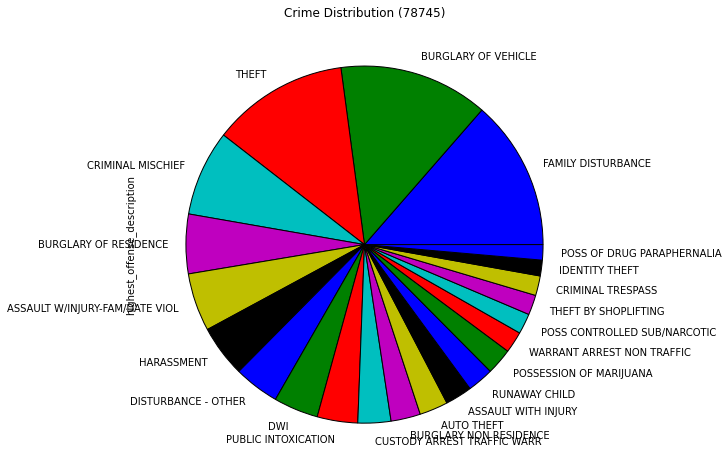

In [9]:
# Examining crime in the 78745 area

df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode

df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages

display(df_45_off)
print("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))

df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q4'></a>
### E. Question 5. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

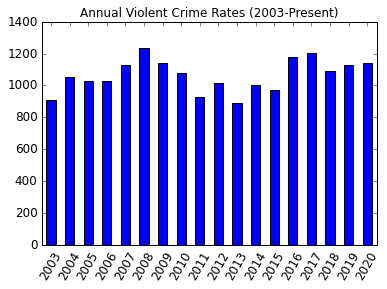

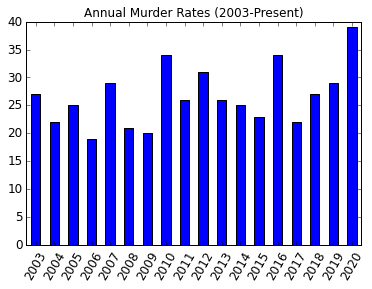

78741.0    0.114742
78701.0    0.097981
78753.0    0.092711
78758.0    0.082907
78702.0    0.074474
78723.0    0.066990
78745.0    0.059558
78744.0    0.054024
78704.0    0.050862
78752.0    0.046382
78721.0    0.031518
78724.0    0.027776
78705.0    0.025563
78757.0    0.019554
78748.0    0.018711
78751.0    0.017235
78759.0    0.013018
78749.0    0.008749
78617.0    0.008486
78722.0    0.008275
78754.0    0.008117
78727.0    0.007801
78729.0    0.007642
78750.0    0.005587
78731.0    0.005481
Name: zip_code, dtype: float64

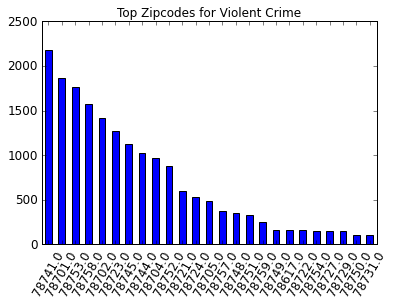

78753.0    0.110879
78741.0    0.106695
78723.0    0.094142
78758.0    0.092050
78744.0    0.069038
78702.0    0.058577
78745.0    0.058577
78752.0    0.056485
78701.0    0.039749
78704.0    0.037657
78721.0    0.033473
78724.0    0.029289
78749.0    0.023013
78751.0    0.016736
78705.0    0.016736
78757.0    0.016736
78727.0    0.014644
78748.0    0.014644
78754.0    0.014644
78759.0    0.014644
78617.0    0.012552
78731.0    0.010460
78750.0    0.008368
78747.0    0.008368
78735.0    0.006276
Name: zip_code, dtype: float64

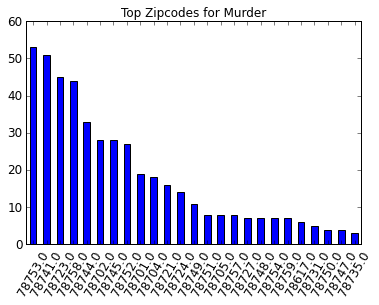

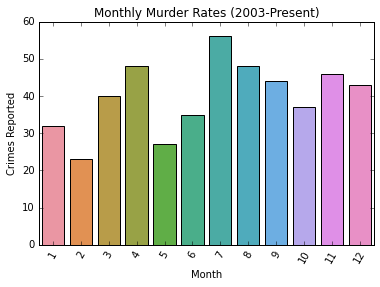

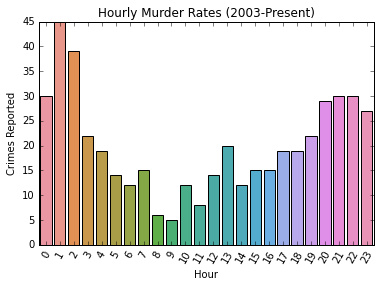

highest_offense_description  AGG ASSAULT  CAPITAL MURDER  MURDER  RAPE
zip_code                                                              
78610.0                                1               0       0     0
78613.0                               14               0       1     6
78617.0                              119               0       6    36
78621.0                                1               0       0     0
78634.0                                1               0       0     0
78652.0                                2               0       0     0
78653.0                               10               0       1     1
78660.0                               66               0       2    17
78664.0                                3               0       0     0
78681.0                                1               0       0     1
78701.0                             1483               1      18   357
78702.0                             1199               3      25   186
78703.0                               55               1       0    36
78704.0                              703               2      16   244
78705.0                              266               2       6   211
78712.0                                1               0       0     1
78717.0                               36               0       1    13
78719.0                               10               0       0     1
78721.0                              509               3      13    73
78722.0                              116               1       0    40
78723.0                             1029              11      34   197
78724.0                              447               2      12    66
78725.0                               22               0       0    11
78726.0                               34               0       1    36
78727.0                               98               2       5    43
78728.0                                7               0       1     4
78729.0                               87               0       2    56
78730.0                               13               0       0     8
78731.0                               47               1       4    52
78732.0                                1               0       0     1
78733.0                                1               0       0     0
78735.0                               82               0       3    11
78736.0                               20               0       0    10
78737.0                                2               0       0     2
78738.0                                1               0       0     0
78739.0                                7               0       0     5
78741.0                             1621               7      44   505
78742.0                               36               0       2     8
78744.0                              784               4      29   208
78745.0                              822               6      22   280
78746.0                               39               0       2    29
78747.0                               55               0       4    27
78748.0                              235               3       4   113
78749.0                              100               1      10    55
78750.0                               71               0       4    31
78751.0                              208               0       8   111
78752.0                              713               6      21   140
78753.0                             1343              12      41   363
78754.0                               99               2       5    48
78756.0                               62               0       2    38
78757.0                              282               2       6    81
78758.0                             1216               8      36   313
78759.0                              132               1       6   108

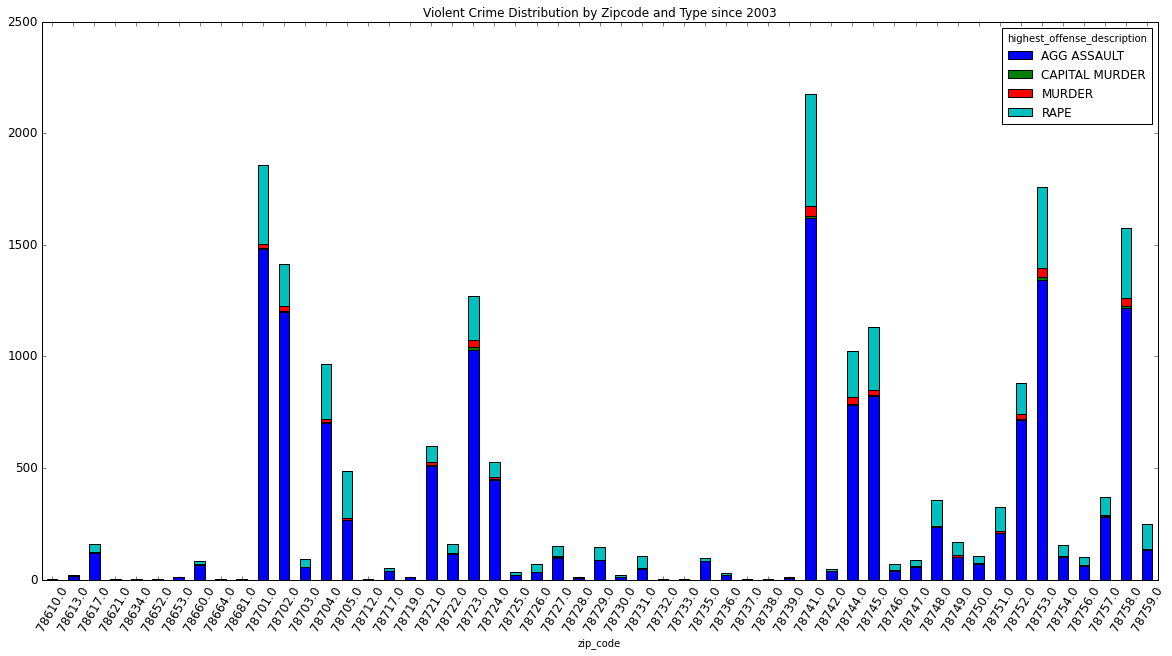

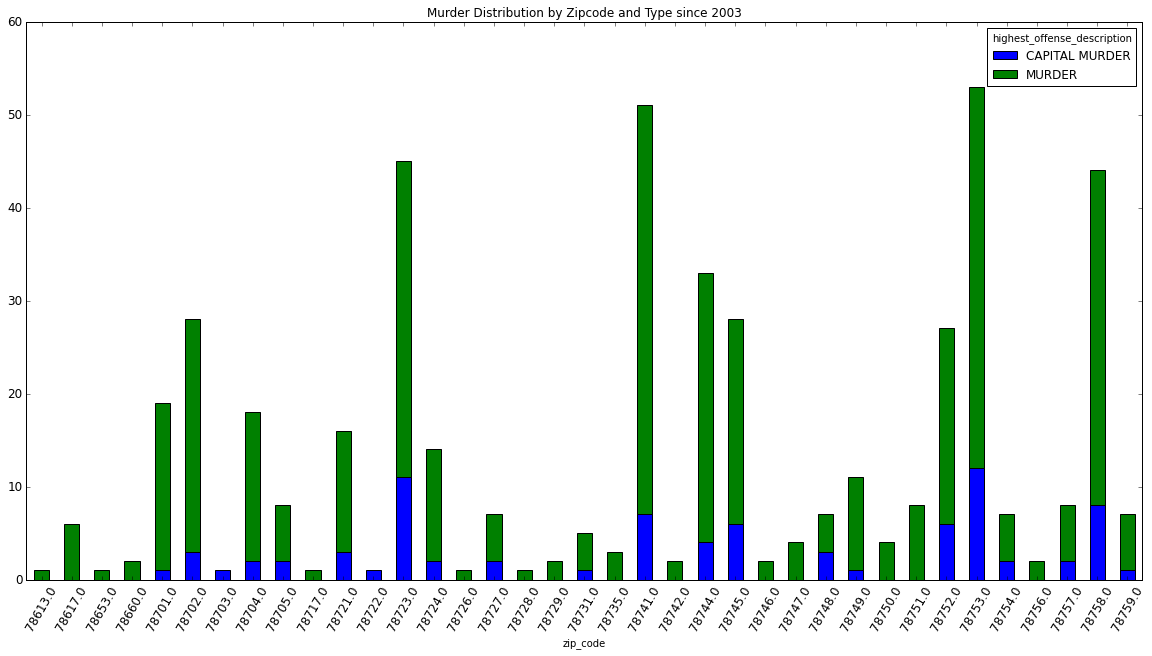

In [10]:
# Creating an overall and separate dataframes for violent crime

df_viol = df.query(
    'highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == "MURDER"]
df_mur_cap = df[df.highest_offense_description == "CAPITAL MURDER"]
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_rape = df[df.highest_offense_description == "RAPE"]

# Visualizing violent crimes per year

viol_per_year = df_viol["year"].value_counts().sort_index()
viol_per_year.plot.bar(
    rot=60, title="Annual Violent Crime Rates (2003-Present)", fontsize=12
)
plt.show()

# Visualizing murders per year

viol_mur_per_year = df_viol_mur.year.value_counts().sort_index()
viol_mur_per_year.plot.bar(
    rot=60, title="Annual Murder Rates (2003-Present)", fontsize=12
)
plt.show()

# Violent Crime by Zipcode

display(df_viol.zip_code.value_counts(normalize=True).head(25))
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top Zipcodes for Violent Crime", fontsize=12, rot=60
)
plt.show()

# Murder by Zipcode

display(df_viol_mur.zip_code.value_counts(normalize=True).head(25))
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    fontsize=12, title="Top Zipcodes for Murder", rot=60
)
plt.show()

mur_by_month = df_viol_mur["month"].value_counts().sort_index()
mur_by_hour = df_viol_mur["hour"].value_counts().sort_index()

# Visualizing monthly & hourly murder rate with Seaborn

v = sns.barplot(x=mur_by_month.index, y=mur_by_month.values)
v.set_xticklabels(v.get_xticklabels(), rotation=60)
v.set(
    xlabel="Month",
    ylabel="Crimes Reported",
    title="Monthly Murder Rates (2003-Present)",
)
plt.show()

# Hourly rate with Seaborn

f = sns.barplot(x=mur_by_hour.index, y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), rotation=60)
f.set(
    xlabel="Hour",
    ylabel="Crimes Reported",
    title="Hourly Murder Rates (2003-Present)",
)
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(
    figsize=(20, 10),
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    fontsize=12,
    stacked=True,
    rot=60,
)
plt.show()

viol_mur_freq = pd.crosstab(
    df_viol_mur.zip_code, df_viol_mur.highest_offense_description
)

viol_mur_freq.plot.bar(
    figsize=(20, 10),
    title="Murder Distribution by Zipcode and Type since 2003",
    fontsize=12,
    stacked=True,
    rot=60,
)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, as of 10/19/2020, murders already totaled 34--the same amount for 2016 and 2010!!

So, you're most likely to get murdered in July, between 1 and 2am, in the 78753 zip code, with 78741 coming in as a very strong alternate. Good to know!

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [11]:
# As a heatmap

mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=11)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="aus_mur_heatmap.html")

k

In [12]:
# Pinpointing individual addresses

mur_coords_add = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

m = folium.Map([30.2672, -97.7431], tiles="OpenStreetMap", zoom_level=12)

for (index, row) in mur_coords_add.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    name = row["address"]
    folium.Marker([lat, lon], popup=name).add_to(m)

m.save(outfile="aus_mur_map.html")

m

#### Are there any addresses where murder occurs frequently?

In [13]:
df_viol_mur.address.value_counts().head(31)

6409 SPRINGDALE RD           3
8800 N IH 35 SVRD SB         3
6407 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
4700 E RIVERSIDE DR          3
1050 SPRINGDALE RD           2
2501 ANKEN DR                2
605 MASTERSON PASS           2
6600 ED BLUESTEIN BLVD SB    2
10503 N LAMAR BLVD           2
2101 ELMONT DR               2
10610 MORADO CIR             2
1711 RUTLAND DR              2
1137 GUNTER ST               2
8912 N LAMAR BLVD            2
9200 NORTH PLZ               2
2915 S IH 35 SVRD NB         2
833 FAIRFIELD DR             2
601 E 15TH ST                2
9010 GALEWOOD DR             2
2508 E RIVERSIDE DR          2
2400 WICKERSHAM LN           2
9601 MIDDLE FISKVILLE RD     2
744 W WILLIAM CANNON DR      2
815 W SLAUGHTER LN           2
9220 N IH 35 SVRD SB         2
6118 FAIRWAY ST              2
2713 S CONGRESS AVE          2
8225 SAM RAYBURN DR          2
7000 DECKER LN               2
201 W 5TH ST                 2
Name: address, dtype: int64

## V. Prediction Modeling 

### Time Series Modeling of the overall dataframe with Facebook Prophet 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


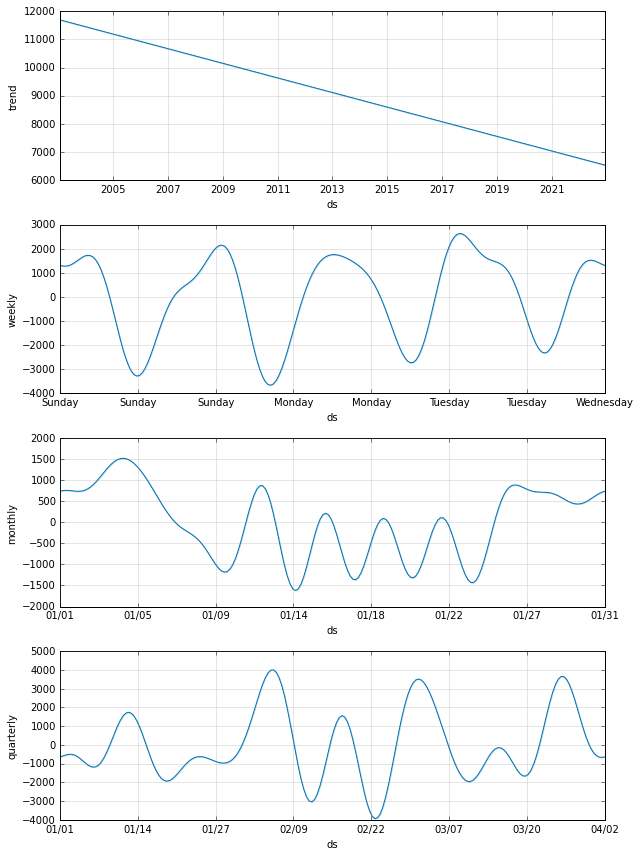

In [14]:
df_fbprophet = df

df_m_1 = df_fbprophet.resample("M").size().reset_index()
df_m_1.columns = ["date", "monthly_crime_count"]
df_m_final_1 = df_m_1.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_1 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_1.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_1.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_1.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_1.fit(df_m_final_1)

future_1 = m_1.make_future_dataframe(periods=24, freq="M")
pred_1 = m_1.predict(future_1)
fig2_1 = m_1.plot_components(pred_1)
fig2_2 = plot_plotly(m_1, pred_1)
fig2_2

### ...now the violent crime dataframe

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


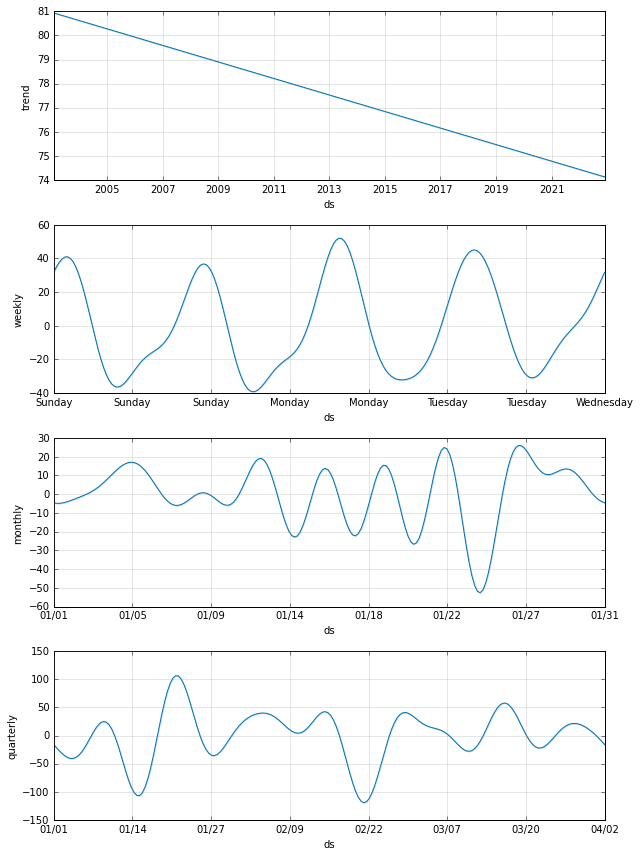

In [15]:
df_viol_fbprophet = df_viol

df_v = df_viol_fbprophet.resample("M").size().reset_index()
df_v.columns = ["date", "monthly_crime_count"]
df_v_final = df_v.rename(columns={"date": "ds", "monthly_crime_count": "y"})

v = Prophet(interval_width=0.95, yearly_seasonality=False)
v.add_seasonality(name="monthly", period=30.5, fourier_order=10)
v.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
v.add_seasonality(name="weekly", period=52.25, fourier_order=10)
v.fit(df_v_final)

future = v.make_future_dataframe(periods=24, freq="M")
pred = v.predict(future)
fig2_1 = v.plot_components(pred)
fig2_3 = plot_plotly(v, pred)
fig2_3

### ...now the murder dataframe 

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


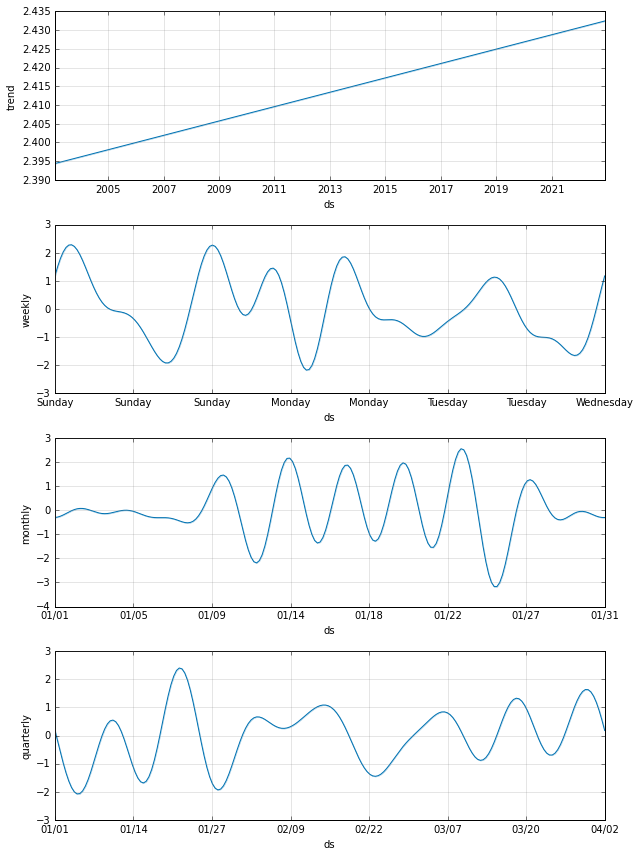

In [16]:
df_viol_mur_fbprophet = df_viol_mur

df_m = df_viol_mur_fbprophet.resample("M").size().reset_index()
df_m.columns = ["date", "monthly_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m = Prophet(interval_width=0.95, yearly_seasonality=False)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=24, freq="M")

pred = m.predict(future)
fig3_1 = m.plot_components(pred)
fig3_3 = plot_plotly(m, pred)
fig3_3

### ...now examining some zip codes

#### 78753

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


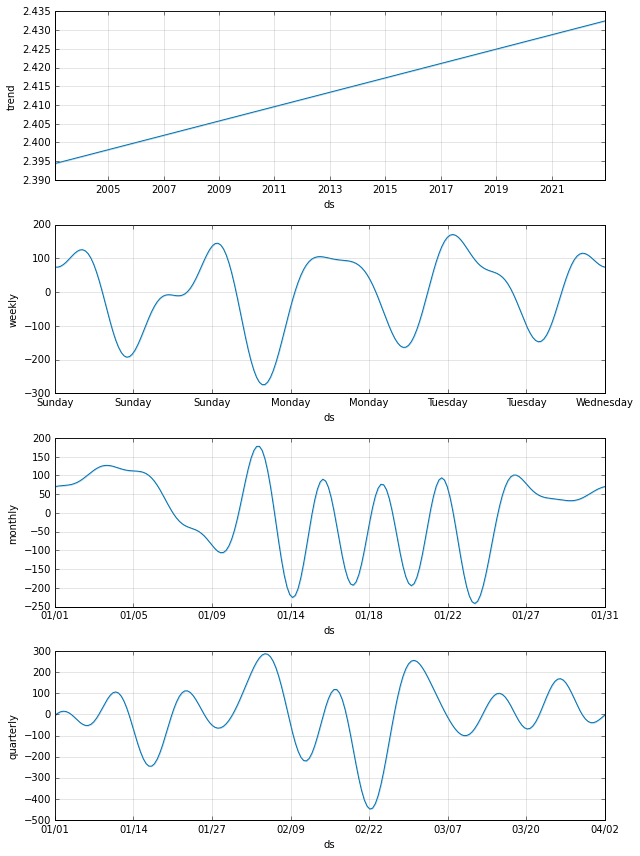

In [17]:
df_fbprophet_53 = df_53

df_m_53 = df_fbprophet_53.resample("M").size().reset_index()
df_m_53.columns = ["date", "monthly_crime_count"]
df_m_final_53 = df_m_53.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_53 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_53.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_53.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_53.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_53.fit(df_m_final_53)

future_53 = m_53.make_future_dataframe(periods=24, freq="M")
pred_53 = m_53.predict(future)
fig2_53 = m_53.plot_components(pred)
fig2_53_1 = plot_plotly(m_53, pred_53)
fig2_53_1

#### 78741

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


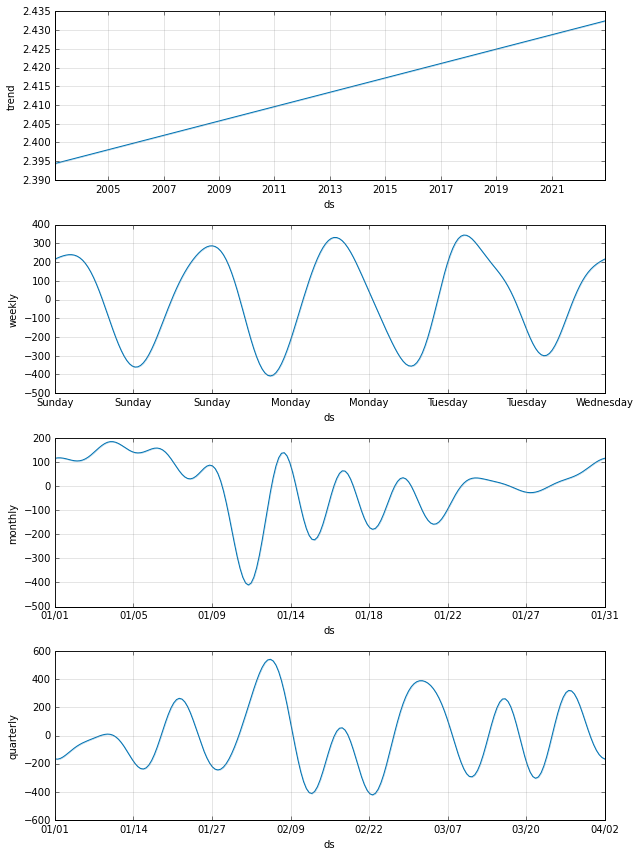

In [18]:
df_fbprophet_41 = df_41

df_m_41 = df_fbprophet_41.resample("M").size().reset_index()
df_m_41.columns = ["date", "monthly_crime_count"]
df_m_final_41 = df_m_41.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_41 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_41.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_41.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_41.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_41.fit(df_m_final_41)

future_41 = m_41.make_future_dataframe(periods=24, freq="M")
pred_41 = m_41.predict(future)
fig2_41 = m_41.plot_components(pred)
fig2_41_1 = plot_plotly(m_41, pred_53)
fig2_41_1

#### 78745

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


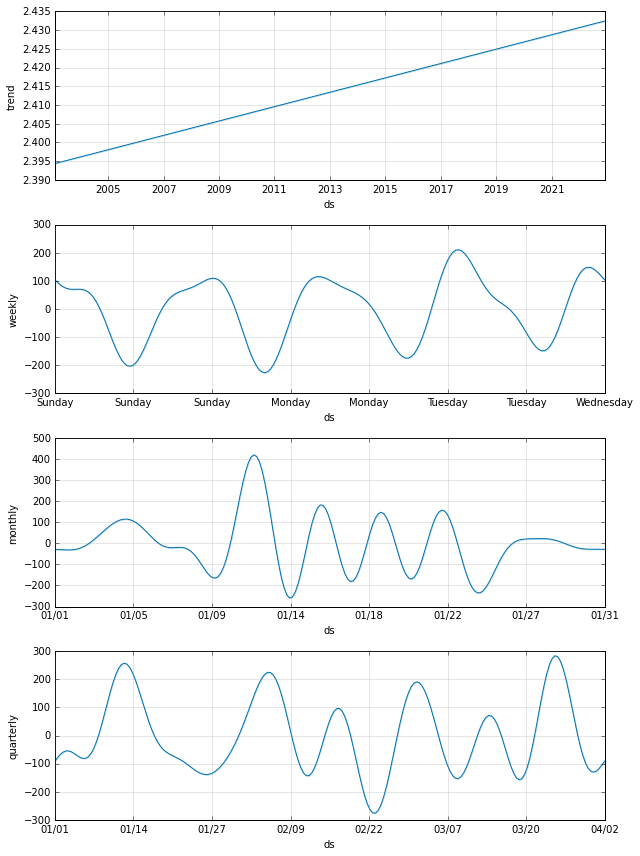

In [19]:
df_fbprophet_45 = df_45

df_m_45 = df_fbprophet_45.resample("M").size().reset_index()
df_m_45.columns = ["date", "monthly_crime_count"]
df_m_final_45 = df_m_45.rename(columns={"date": "ds", "monthly_crime_count": "y"})

m_45 = Prophet(interval_width=0.95, yearly_seasonality=False)
m_45.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m_45.add_seasonality(name="quarterly", period=91.5, fourier_order=10)
m_45.add_seasonality(name="weekly", period=52.25, fourier_order=10)
m_45.fit(df_m_final_45)

future_45 = m_45.make_future_dataframe(periods=24, freq="M")
pred_45 = m_45.predict(future)
fig2_45 = m_45.plot_components(pred)
fig2_45_1 = plot_plotly(m_45, pred_45)
fig2_45_1